In [1]:
# this evaluation simulates the estimation of previously unseen content
# training of all estimators is made on only a part of data disjuctive from testing part of data (see [3])
# accuracy might be a bit worse than in production, since vector training is done on smaller part of data 

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
# [3] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [6]:
d2v_wrapper_base = D2VWrapper(content_categories=product_list,
                              vector_length=500)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
d2v_wrapper_base.init_model_vocab(content_basepath="../../data/content/playground/auto/nostem",
                                  basepath_suffix="_content.csv", drop_short_docs=10)

2017-04-26 16:17:32,224 : INFO : Loaded 51488 all_base_vocab_docs from 14 categories
2017-04-26 16:17:32,225 : INFO : Filtering all_base_vocab_docs shorter than 10 tokens from vocab sample
2017-04-26 16:17:32,248 : INFO : 43478 all_base_vocab_docs included in vocab init
2017-04-26 16:17:32,258 : INFO : Initializing 43478 CategorizedDocuments
2017-04-26 16:17:34,965 : INFO : Initialized 43478 headers of 43478 for vectorization
2017-04-26 16:17:34,967 : INFO : collecting all words and their counts
2017-04-26 16:17:34,968 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-26 16:17:35,158 : INFO : PROGRESS: at example #10000, processed 1462558 words (7726914/s), 41870 word types, 10000 tags
2017-04-26 16:17:35,364 : INFO : PROGRESS: at example #20000, processed 3020434 words (7575152/s), 69836 word types, 20000 tags
2017-04-26 16:17:35,553 : INFO : PROGRESS: at example #30000, processed 4504158 words (7887159/s), 84891 word types, 30000 tags
2017-04-26 

In [7]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [9]:
# the whole magic is happening here
# train of first Doc2Vec model, then superior LogReg classifier on Doc2Vec vectors

# results collection
accuracies = []
cat_accuracies = pd.DataFrame(columns=product_list)
logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

all_base_vocab_docs = d2v_wrapper_base.all_content_tagged_docs
doc_labels = all_base_vocab_docs.apply(lambda doc: doc.category_expected)

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(all_base_vocab_docs, doc_labels):

    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)

    train_docs = all_base_vocab_docs[train_doc_indices]
    test_docs = all_base_vocab_docs[test_doc_indices]

    d2v_wrapper_fold = D2VWrapper(content_categories=product_list, vector_length=500)
    d2v_wrapper_fold.init_vocab_from_docs(train_docs)

    # docs vectors embedding training
    d2v_wrapper_fold.train_model(epochs=5)
    train_doc_vectors_labeled = d2v_wrapper_fold.infer_vocab_content_vectors()
    train_doc_vectors = train_doc_vectors_labeled.iloc[:,:-1]
    train_y = train_doc_vectors_labeled.iloc[:,-1]

    # superior classifier training
    logging.info("Fitting classifier")
    log_reg_classifier = LogisticRegression(C=0.3, solver="sag", multi_class='ovr', n_jobs=8, max_iter=1000)
    log_reg_classifier.fit(train_doc_vectors, train_y)

    # testing
    # test docs vectors inference
    test_docs_vectors = d2v_wrapper_fold.infer_content_vectors(test_docs)

    logging.info("Predicting")
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = log_reg_classifier.predict(test_docs_vectors)

    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = log_reg_classifier.predict_proba(test_docs_vectors)
    class_ordered = list(log_reg_classifier.classes_)

    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)), class_actual_index]

    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)), class_expected_index]

    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    logits = logits.append(new_logits)

    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper_fold.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper_fold.content_categories))

2017-04-26 16:18:15,119 : INFO : Initialized 34776 headers of 34776 for vectorization
2017-04-26 16:18:15,121 : INFO : collecting all words and their counts
2017-04-26 16:18:15,122 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-26 16:18:15,327 : INFO : PROGRESS: at example #10000, processed 1390009 words (6780068/s), 42705 word types, 43470 tags
2017-04-26 16:18:15,535 : INFO : PROGRESS: at example #20000, processed 2729639 words (6478656/s), 65027 word types, 43477 tags
2017-04-26 16:18:15,752 : INFO : PROGRESS: at example #30000, processed 4085712 words (6263677/s), 82476 word types, 43477 tags
2017-04-26 16:18:15,893 : INFO : PROGRESS: at example #40000, processed 4733566 words (4615891/s), 90605 word types, 43477 tags
2017-04-26 16:18:15,931 : INFO : PROGRESS: at example #50000, processed 4777896 words (1196421/s), 90900 word types, 43477 tags
2017-04-26 16:18:15,964 : INFO : PROGRESS: at example #60000, processed 4822534 words (1368136/s), 

In [16]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-26 20:15:22,987 : INFO : split accuracies: [0.86980004596644445, 0.86941027704333829, 0.86854514088556645, 0.86424298205246208, 0.86962025316455693]
2017-04-26 20:15:22,988 : INFO : mean accuracy: 0.868323739822
2017-04-26 20:15:22,996 : INFO : categories accuracies: 
        amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.381679  0.944551   0.312500  0.333333  0.868147  0.474265  0.546667   
0  0.412214  0.944551   0.329843  0.444444  0.865371  0.437500  0.631111   
0  0.480916  0.940710   0.293194  0.444444  0.867453  0.452206  0.546667   
0  0.412214  0.940437   0.303665  0.365079  0.854962  0.512915  0.531250   
0  0.384615  0.936066   0.335079  0.435484  0.875781  0.505535  0.558036   

   devstudio       cdk  developertoolset      rhel  softwarecollections  \
0   0.838519  0.066667               0.0  0.960092                  0.0   
0   0.832593  0.133333               0.0  0.952381                  0.0   
0   0.841481  0.285714               0.0 

In [11]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.168571,72
12,mobileplatform,0.416190,101
3,datagrid,0.404557,314
0,amq,0.414328,654
2,webserver,0.314856,956
6,bpmsuite,0.562746,1123
5,brms,0.476484,1358
7,devstudio,0.838127,3373


In [12]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
logits["doc_id"] = logits["doc_id"].apply(lambda x: int(x))
logits = logits.set_index("doc_id")
logits.head(25)

,actual_class,actual_prob,expected_class,expected_prob
doc_id,,,,
13414,eap,0.770647,eap,0.770647
37119,rhel,0.985029,rhel,0.985029
29486,devstudio,0.564044,bpmsuite,0.398109
42048,openshift,0.879261,openshift,0.879261
33111,devstudio,0.538562,devstudio,0.538562
20663,rhel,0.490572,fuse,0.373928
12440,eap,0.983318,eap,0.983318
2785,eap,0.977992,eap,0.977992
8043,eap,0.979919,eap,0.979919


In [13]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = logits[logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['eap', 'rhel', 'openshift', 'devstudio', 'fuse', 'brms'], dtype=object)

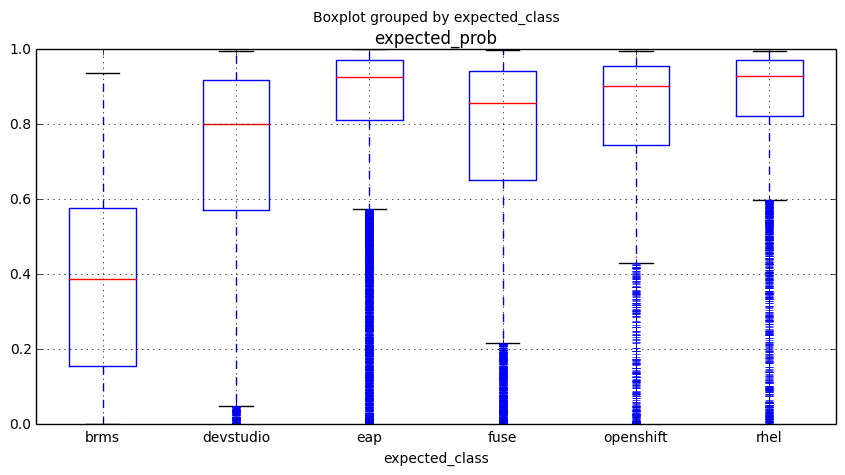

In [14]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [18]:
# incorrect classification characteristics
wrong_docs_ids = pd.Series(logits[logits["expected_class"] != logits["actual_class"]].index)

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper_base.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

count     5725.000000
mean       141.896419
std        438.600876
min         10.000000
25%         19.000000
50%         33.000000
75%         79.000000
max      12476.000000
Name: doc_id, dtype: float64

In [21]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(logits)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
# data need to be indexed incrementally for later plotting
correct_docs.index=np.arange(len(correct_docs))
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper_base.get_doc_content(doc_id, word_split=True))
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    37753.000000
mean       136.661669
std        627.510571
min         10.000000
25%         26.000000
50%         40.000000
75%        104.000000
max      79212.000000
dtype: float64

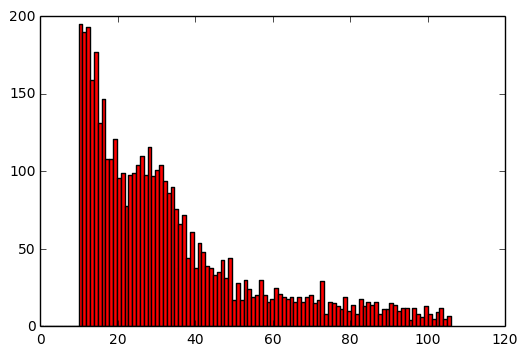

In [22]:
# missclassified docs length distribution
bordering_q = 0.8
bordering_q_value = int(wrong_docs_len.quantile(q=bordering_q))
plt.hist(wrong_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="r")
plt.show()

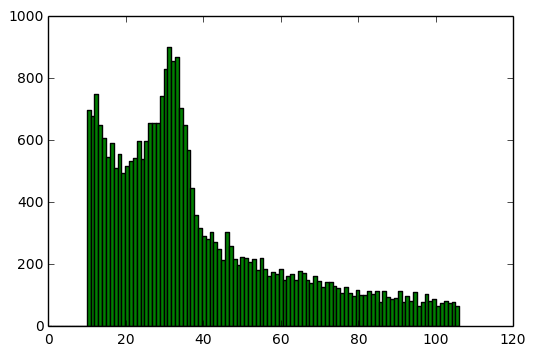

In [23]:
# correctly classified length distribution
plt.hist(correct_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="g")
plt.show()

<Container object of 106 artists>

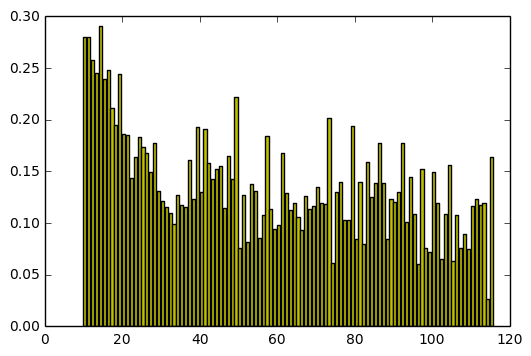

In [24]:
# distribution of incorrectly/correctly classified ratio by docs length
doc_len_error = (wrong_docs_len.value_counts() / correct_docs_len.value_counts())
ploted_doc_len_error = doc_len_error[:bordering_q_value]

plt.bar(ploted_doc_len_error.index, ploted_doc_len_error, color="y")

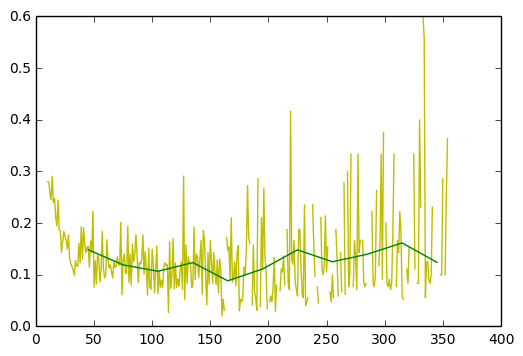

In [25]:
error_plot_border = 350
error_ploted = doc_len_error[:error_plot_border]
plt.plot(error_ploted.index, error_ploted, color="y")

mean_range = 30
mean_plot_ids = range(mean_range, error_plot_border+mean_range, mean_range)
mean_plot_vals = map(lambda mean_id: error_ploted.iloc[mean_id-5-mean_range: mean_id+5-mean_range].mean(), mean_plot_ids)
mean_plot = pd.Series(mean_plot_vals)
mean_plot.index = np.array(mean_plot_ids)-mean_range/2
plt.plot(mean_plot.index , mean_plot, color="g")

In [27]:
# docs get associated with its content
logits["content_len"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                len(d2v_wrapper_base.get_doc_content(int(doc_id), word_split=True))).values
logits["content"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                d2v_wrapper_base.get_doc_content(int(doc_id), word_split=False)).values

In [28]:
# correctly classified docs with its content
logits[logits["actual_class"] != logits["expected_class"]][:30]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
29486,devstudio,0.564044,bpmsuite,0.398109,24,let process modeled steps type user tasks star...
20663,rhel,0.490572,fuse,0.373928,275,red hat gluster storage software scale storage...
31952,eap,0.487096,devstudio,0.317105,25,created new jsf project picked jsf facelets js...
32022,eap,0.475286,devstudio,0.040223,27,april oracle longer post updates java https ww...
24,openshift,0.685353,amq,0.157621,3732,list ruby gems included cfme cloudforms red ha...
28134,eap,0.530612,brms,0.134079,47,like add business central iframe web portal de...
651,fuse,0.957538,amq,0.013637,43,fuse shut cleanly set process pid zero nstance...
20617,eap,0.848576,fuse,0.037441,12,currently source main site work currently prod...
154,eap,0.421805,amq,0.001778,10,view message uses parts font color background ...


In [29]:
# misclassified docs with its content 
content_array = logits[logits["actual_class"] != logits["expected_class"]].iloc[:10]["content"].values
content_index = logits[logits["actual_class"] != logits["expected_class"]].iloc[:10].index.values
content_both = ["%s: %s" % (content_index[x], content_array[x]) for x in range(len(content_index))]
print reduce(lambda x, y: "%s\n\n%s" % (x, y), content_both)
# print d2v_wrapper.get_doc_content(doc_id, word_split=False)

29486: let process modeled steps type user tasks start step step step step end step realize data entered step incorrect want rollback step start step.

20663: red hat gluster storage software scale storage solution provides flexible affordable unstructured data storage unifies data storage infrastructure increases performance improves availability manageability meet enterprise level storage challenges following packages upgraded later upstream version glusterfs redhat storage server security fix glusterfs server rpm package write file predictable world readable tmp directory local attacker potentially use flaw escalate privileges root modifying shell script installation glusterfs server package cve issue discovered florian weimer red hat product security bug fix bricks remain stopped server quorum longer met server quorum disabled ensure bricks maintenance started incorrectly metadata cache translator updated improve red hat gluster storage performance reading small files gluster volum

In [30]:
act_cdk = logits[logits["actual_class"] == "cdk"]
act_cdk[act_cdk["expected_class"] == "cdk"]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
33342,cdk,0.524306,cdk,0.524306,71,installing cdk kit windows run following comma...
33325,cdk,0.428992,cdk,0.428992,64,red hat container development kit platform dev...
33322,cdk,0.780270,cdk,0.780270,73,red hat container development kit platform dev...
33300,cdk,0.505745,cdk,0.505745,31,use information chapter troubleshoot vagrant c...
33286,cdk,0.541198,cdk,0.541198,2529,document describes install software components...
33292,cdk,0.545190,cdk,0.545190,38,prepare mac development running cdk steps down...
33304,cdk,0.391964,cdk,0.391964,37,prepare microsoft windows development run cont...
33303,cdk,0.503196,cdk,0.503196,37,red hat container development kit cdk set tool...
33294,cdk,0.540848,cdk,0.540848,1107,red hat development suite installer provides e...


In [31]:
# content of particular not successful category
# does not have any distinctive characteristics, it just contains too little documents
content_array = logits[logits["actual_class"] == "cdk"]["content"].values
content_index = logits[logits["actual_class"] == "cdk"].iloc[:10].index.values
content_both = ["%s: %s" % (content_index[x], content_array[x]) for x in range(len(content_index))]
print reduce(lambda x, y: "%s\n\n%s" % (x, y), content_both)

31925: wanted post open channel users interact directly docs team devsuite devstudio let know useful unhelpful like document feature let present information brand new red hat development suite installer red hat development suite installer red hat customer portal windows want quick easy way automatically set configure devsuite components installer try feedback requests information couldn wanted know let know.

40137: article discusses container development kit tooling jboss developer studio note article details steps red hat jboss developer studio container development kit steps changed newer versions products latest version document container development kit tooling jboss developer studio red hat container development kit cdk pre built container development environment based red hat enterprise linux help started developing container based applications quickly set red hat container development kit jboss developer studio follows installation configuration ways automatically install confi